In [1]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Alphabet Inc Class A) using the 90 day stock price.

In [4]:
# Import the Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [5]:
# Get stock quote
df =web.DataReader("GOOGL", data_source="yahoo", start="2010-01-01", end="2020-01-05")

#show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,313.013000,310.300293,312.687683,310.300293,2437100.0,310.300293
2010-01-04,315.070068,312.432434,313.788788,313.688690,3908400.0,313.688690
2010-01-05,314.234222,311.081085,313.903900,312.307312,6003300.0,312.307312
2010-01-06,313.243256,303.483490,313.243256,304.434448,7949400.0,304.434448
2010-01-07,305.305298,296.621613,305.005005,297.347351,12815700.0,297.347351
...,...,...,...,...,...,...
2019-12-27,1367.050049,1353.000000,1364.000000,1354.640015,1160600.0,1354.640015
2019-12-30,1357.000000,1337.839966,1356.810059,1339.709961,999700.0,1339.709961
2019-12-31,1340.660034,1332.130005,1335.790039,1339.390015,975700.0,1339.390015


In [6]:
# Get the number of rows and columns in the dataset
df.shape

(2519, 6)

C:\Users\PKG\.conda\envs\ml\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


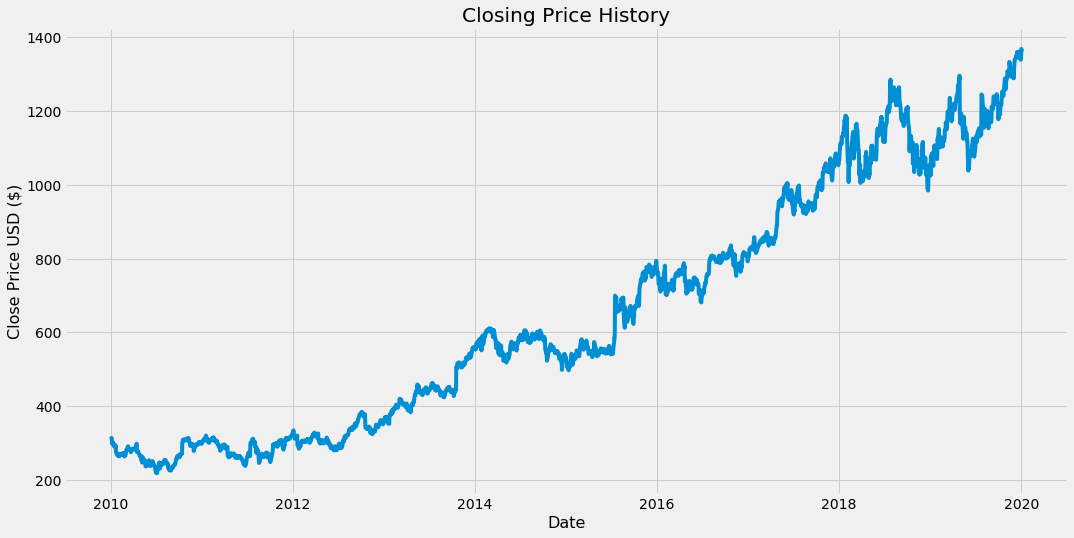

In [8]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(df["Close"])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.show()

In [9]:
# Create a new dataframe of "Close" Column
data = df.filter(['Close'])

# Convert dataframe to numpy array
dataset = data.values

# Get train rows for model
data_train_len = math.ceil(len(dataset) * 0.8)
data_train_len

2016

In [10]:
# Data Preprocessing / Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.08001121],
       [0.08295655],
       [0.0817558 ],
       ...,
       [0.97453985],
       [1.        ],
       [0.99377619]])

In [12]:
# Create trainign dataset
training_data = scaled_data[0:data_train_len,:]

# Split x_train & y_train
x_train = []
y_train = []
for i in range(90, len(training_data)):
    x_train.append(training_data[i-90:i, 0])
    y_train.append(training_data[i,0])

In [24]:
# Create testing dataset
testing_data = scaled_data[data_train_len-90:, :]

# Split to x_test & y_test
x_test = []
y_test = dataset[data_train_len:, :]
for i in range(90, len(testing_data)):
    x_test.append(testing_data[i-90:i, 0]) 

In [25]:
# Convert training & testing sets to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test = np.array(x_test)

In [16]:
# Reshape the x_train Dataset (LSTM expects data in 3D - No. os sample, timesteps and features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1926, 90, 1)

In [28]:
# Reshape the x_test Dataset (To match training set and test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(503, 90, 1)

In [17]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
# Model Compilation & Optimization
# Optimizer is used to improve upon the loss function
# Loss function is used to measure how well the model performed oon training
model.compile(optimizer='adam', loss="mean_squared_error")

In [20]:
# Training the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





1926/1926 [==============================] - 520s 270ms/step - loss: 0.0010


In [29]:
# Get the model's prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [31]:
# Get the RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

31.7789626120145

C:\Users\PKG\.conda\envs\ml\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


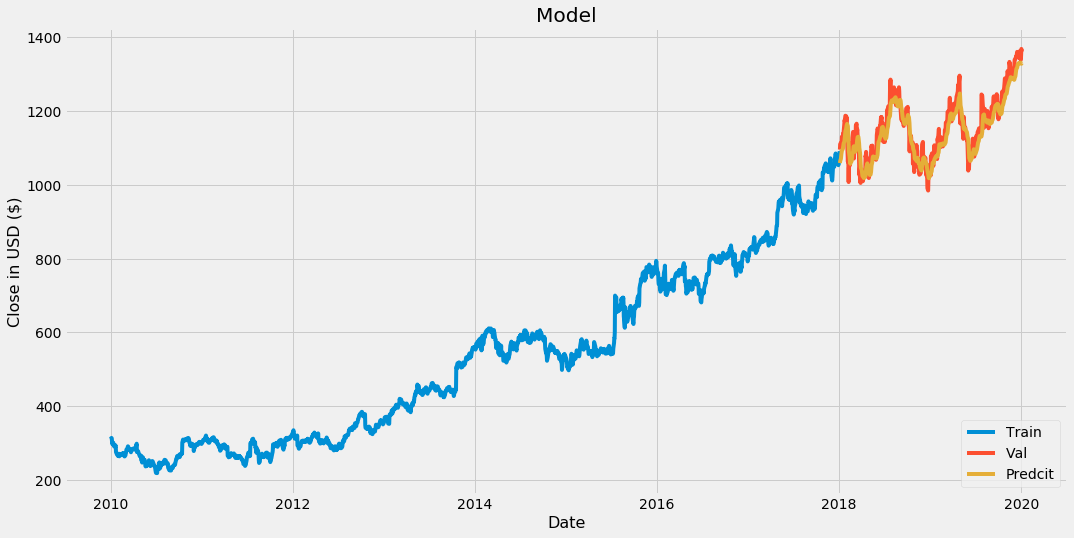

In [32]:
# Plot the data
train_data = data[0:data_train_len]
validation_data = data[data_train_len:]
validation_data['Prediction'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Close in USD ($)", fontsize = 16)
plt.plot(train_data['Close'])
plt.plot(validation_data[['Close', 'Prediction']])
plt.legend(['Train', 'Val', 'Predcit'], loc="lower right")

In [33]:
# Show the valid & predicted price
validation_data

,Close,Prediction
Date,,
2018-01-04,1095.760010,1059.232300
2018-01-05,1110.290039,1064.188110
2018-01-08,1114.209961,1070.976562
2018-01-09,1112.790039,1078.144775
2018-01-10,1110.140015,1084.395020
...,...,...
2019-12-27,1354.640015,1330.902710
2019-12-30,1339.709961,1331.691528
2019-12-31,1339.390015,1330.424927


In [41]:
# Get the quote
google_quote = web.DataReader('GOOGL', data_source='yahoo', start="2010-01-01", end="2020-01-02")
#Create a new dataframe
new_df = google_quote.filter(['Close'])
# Get last 90 days data
last_90_days = new_df[-90:].values
#Scale the new values between 0 and 1
last_90_days_scaled = scaler.transform(last_90_days)
# Create list and append for testing
X_test = []
X_test.append(last_90_days_scaled)
# Convert test data in numpy array
X_test = np.array(X_test)
# Reshape the data to 3D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted scaled price
predicted_price = model.predict(X_test)
# Inverse scleing
predicted_price = scaler.inverse_transform(predicted_price)
# PRint the predicted price
print(predicted_price)

[[1330.177]]


In [42]:
google_quote = web.DataReader('GOOGL', data_source='yahoo', start="2020-01-03", end="2020-01-03")
print(google_quote['Close'])

Date
2020-01-02    1368.680054
2020-01-03    1361.520020
Name: Close, dtype: float64
